In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

In [2]:
# dataset
tweet = pd.read_csv("Tweets.csv")
tweet.drop(['selected_text', 'textID'], axis=1, inplace=True, errors="ignore")
tweet.dropna(inplace=True)
tweet.reset_index(drop=True, inplace=True)
tweet.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [3]:
# Setup stopwords & lemmatizer
stopwords_set = set(stopwords.words('english'))
# Keeping important negations
negation_words = {"no", "not", "nor", "never"}
filtered_stopwords = stopwords_set - negation_words
lemmatizer = WordNetLemmatizer()

In [4]:
# Text cleaning function
def clean_text(text):
    # Removing links and mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    
    # Keeping hashtags as they may have sentiment value
    text = re.sub(r"[^a-zA-Z#]", " ", text)
    text = text.lower()

    tokens = word_tokenize(text)

    # POS tagging
    tagged_tokens = pos_tag(tokens)

    # Lemmatization with POS
    lemmatized = [
        lemmatizer.lemmatize(
            word,
            {
                "J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV
            }.get(tag[0].upper(), wordnet.NOUN)
        )
        for word, tag in tagged_tokens
        if word not in filtered_stopwords and len(word) > 1
    ]

    return " ".join(lemmatized)

In [5]:
# Apply preprocessing
tweet['clean_text'] = tweet['text'].apply(clean_text)


# Vectorization (TF-IDF)
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)
X = vectorizer.fit_transform(tweet['clean_text'])
tweet.head()

,text,sentiment,clean_text
0,"I`d have responded, if I were going",neutral,respond go
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bully
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son put release already buy


In [6]:
# Label encoding
y = tweet['sentiment']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=45, stratify=y_encoded
)

Accuracy: 0.7065
              precision    recall  f1-score   support

    negative       0.74      0.63      0.68      1167
     neutral       0.64      0.75      0.69      1668
    positive       0.79      0.72      0.75      1287

    accuracy                           0.71      4122
   macro avg       0.72      0.70      0.71      4122
weighted avg       0.71      0.71      0.71      4122



<Figure size 600x600 with 0 Axes>

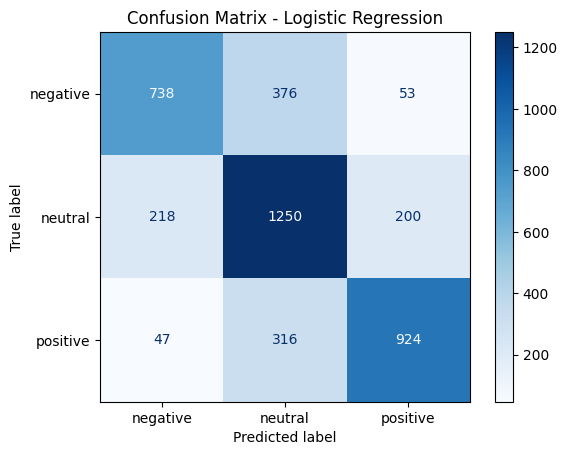

In [7]:
# Logistic Regression model
model = LogisticRegression(max_iter=500, C=2.0, solver="lbfgs")
model.fit(X_train, y_train)


# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [8]:
# Saving model & preprocessing objects
joblib.dump(model, "sentiment_model_logreg.pkl")
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(encoder, "label_encoder.pkl")
joblib.dump(accuracy, "logreg_accuracy.pkl")

['logreg_accuracy.pkl']

In [11]:
# Test prediction
text = "The food delivery took two hours, and the order was still wrong. Never ordering again."
clean = clean_text(text)
vect = vectorizer.transform([clean])
pred = model.predict(vect)
print("Predicted:", encoder.inverse_transform(pred))

Predicted: ['negative']
